In [ ]:
!pip install pytorch-lightning

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
class TransformData():
    def __init__(self, RHF=0.5, RVF=0.5, RR=45, RRC=96):
        self.data_tr = transforms.Compose([
            transforms.RandomHorizontalFlip(p=RHF),
            transforms.RandomVerticalFlip(p=RVF),
            transforms.RandomRotation(RR),
            transforms.RandomResizedCrop(RRC,scale=(0.8,1.0),ratio=(1.0,1.0)),
            transforms.ToTensor()])
    def __call__(self):
        return self.data_tr


In [4]:
class LiverDataset():
    def __init__(self, path, transform=None):
        self.dataset = datasets.ImageFolder(path, transform=transform)

    def __len__(self):
      return len(self.dataset)

    def setup(self):
        self.train, self.test = train_test_split(self.dataset, train_size = 100)
        return self.train, self.test

    def train_dataloader(self, batch_size=64, shuffle=True):
        train, _ = self.setup()
        return DataLoader(train, batch_size=batch_size, shuffle=shuffle)

    def test_dataloader(self, batch_size=64, shuffle=True):
        _, test = self.setup()
        return DataLoader(test, batch_size=batch_size, shuffle=shuffle)

    def dataset(self):
        return self.train_dataloader(),  self.test_dataloader()


In [5]:
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils
import sys
%matplotlib inline

In [6]:
!cp "/content/drive/MyDrive/ProjetMboup/IMAGES_ECHO_LABELLISEES-20210617T165342Z-001.zip" '.'

In [7]:
!unzip -q IMAGES_ECHO_LABELLISEES-20210617T165342Z-001.zip

In [8]:
!rm IMAGES_ECHO_LABELLISEES-20210617T165342Z-001.zip

In [9]:
path = '/content/IMAGES_ECHO_LABELLISEES/'

In [10]:
transform = TransformData()

In [11]:
dataset = LiverDataset(path, transform=transform())

In [12]:
train_dl = dataset.train_dataloader(batch_size=5, shuffle=True)
test_dl = dataset.test_dataloader(batch_size=5, shuffle=True)

In [13]:
class ShowImage():
    def __init__(self, img):
        plt.figure(figsize=(10, 6))
        # Transformer le tenseur pytorch en numpy array
        self.img_np = img.numpy()
        # Changer le format des dimensions en H*W*C
        self.img_np_tr = np.transpose(self.img_np,(1,2,0))
        print(self.img_np_tr.shape)

    def show(self):
        plt.imshow(self.img_np_tr, interpolation='nearest')

In [14]:
img, label = next(iter(train_dl))
print(img.shape)

torch.Size([5, 3, 96, 96])


(96, 96, 3)


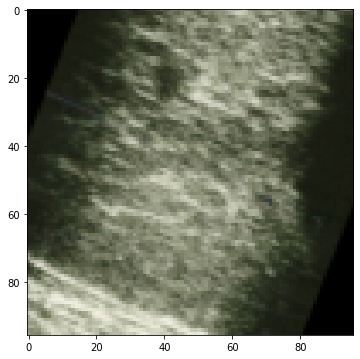

In [15]:
# Creer une grille de 40 images, 8 images par rangée
x_grid = utils.make_grid(img[:1], nrow=2, padding = 4)
ShowImage(x_grid).show()

In [16]:
class LiverModel(pl.LightningModule):
    
    def __init__(self):
        super(LiverModel, self).__init__()
        
        # Model  ###############################################################################
        # Pretrained VGG16
        use_pretrained = True
        self.net = models.vgg16(pretrained=use_pretrained)
        # Change Output Size of Last FC Layer (4096 -> 1)
        self.net.classifier[6] = nn.Linear(in_features=self.net.classifier[6].in_features, out_features=4)
        # Specify The Layers for updating
        params_to_update = []
        update_params_name = ['classifier.6.weight', 'classifier.6.bias']

        for name, param in self.net.named_parameters():
            if name in update_params_name:
                param.requires_grad = True
                params_to_update.append(param)
            else:
                param.requires_grad = False
        # Set Optimizer
        self.optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
    
    # Method  ###############################################################################
    # Set Train Dataloader
    #@pl.data_loader
    
    
    def forward(self, x):
        return self.net(x)

    def crossentropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.crossentropy_loss(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.crossentropy_loss(logits, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.crossentropy_loss(logits, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        #generator_optim = torch.optim.Adam(self.generator(), lr=1e-3)
        #disc_optim = torch.optim.Adam(self.discriminator(), lr=1e-3)
        return optimizer

In [17]:
model = LiverModel()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [19]:
trainer = pl.Trainer(gpus=1, max_epochs=3, progress_bar_refresh_rate=20)
trainer.fit(model, train_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | VGG  | 134 M 
------------------------------
16.4 K    Trainable params
134 M     Non-trainable params
134 M     Total params
537.108   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [20]:
trainer.test(test_dataloaders=test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:349: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f'Your {mode}_dataloader has `shuffle=True`, it is best practice to turn'



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': -24.123512268066406}
--------------------------------------------------------------------------------


[{'test_loss': -24.123512268066406}]

In [22]:
class TrainModel():
    import torch
    import torch.nn as nn
    import torchvision
    from torchsummary import summary
    from torchvision import transforms
    from torch.utils.data import DataLoader, TensorDataset
    import numpy as np
    import matplotlib.pyplot as plt
    import torch.nn.functional as F
    from torch.utils.tensorboard import SummaryWriter
    #%matplotlib inline

    def calculate_accuracy(top_class,labels):
      if top_class.shape != labels.shape:
        labels.view(*top_class.shape)
      equals = top_class == labels
      accuracy = torch.mean(equals.type(torch.FloatTensor))
      return accuracy.item()

    #TrainBatch
    def train_batch(model, im, labe, loss_fn, optimizer=None):
      if torch.cuda.is_available()==True:
        im=im.type(torch.float).to(torch.device("cuda:0"))
        labe=labe.to(torch.device("cuda:0"))

      labe_pred = model(im)
      loss = loss_fn(labe_pred, labe.long())
      top_prob, top_class = torch.exp(labe_pred).topk(1, dim=1)
      batch_accuracy = calculate_accuracy(top_class, labe)
      if optimizer is not None :
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
      return loss.item(), batch_accuracy

    #TrainEpoch
    def train_epoch(model, train_dl, test_dl, optimizer, epoch, loss_fn):
      running_loss = 0.
      test_loss = 0.
      train_accuracy = 0.
      val_accuracy = 0.
      model.train()
      for im,lab in train_dl:
        optimizer.zero_grad()
        x,y = train_batch(model, im, lab, loss_fn, optimizer)
        running_loss += x
        train_accuracy += y

      with torch.no_grad():
        model.eval()
        for im_test, lab_test in test_dl:
          x,y = train_batch(model, im_test, lab_test, loss_fn)
          test_loss += x
          val_accuracy += y
        model.train()

      return running_loss/len(train_dl), train_accuracy/len(train_dl), test_loss/len(train_dl), val_accuracy/len(train_dl)


    #Visualiser Tensorboard
    def visualiser_tensorboard(train_losses, test_losses, train_accuracies, val_accuracies):
        writer = SummaryWriter()
        for n_iter in range(len(train_losses)):
          writer.add_scalar('Loss/Train', np.array(train_losses).squeeze()(n_iter), n_iter)
          writer.add_scalar('Accuracy/Train', np.array(train_accuracies).squeeze()(n_iter), n_iter)
          writer.add_scalar('Loss/Test', np.array(test_losses).squeeze()(n_iter), n_iter)
          writer.add_scalar('Accuracy/Test', np.array(val_accuracies).squeeze()(n_iter), n_iter)
        writer.close()  


    #Train_model
    def train_model(epochs, model, optimizer, train_dl, test_dl, loss_fn):
      train_losses = []
      test_losses = []
      train_accuracies = []
      val_accuracies = []
      for epoch in range(epochs):
        x, y, z, t = train_epoch(model, train_dl, test_dl, optimizer, epoch, loss_fn)
        train_losses.append(x)
        test_losses.append(y)
        train_accuracies.append(z)
        val_accuracies.append(t)
        print(f"""Epoch : {epoch}/{epochs}, 
                  Training_loss : {train_losses[-1]},
                  Train_accuracy : {train_accuracies[-1]},
                  Test_loss : {test_losses[-1]},
                  Test_accuracy : {val_accuracies[-1]}""")
      visualiser_tensorboard(train_losses, test_losses, train_accuracies, val_accuracies)